# 2018 World Cup review
In this Google Colab notebook, I will develop several alternatives for the different stages seen in class (Week 3: Unsupervised Learning Summary - I). 

## 0. Data Loading and Libraries

Let's first make the preoceeding imports.

In [187]:
from google.colab import files
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import cluster

Now, the next step is to choose (load) the data file (a .csv file) into the Google Colab Notebook environment.

In [188]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving worldcup_2018_final_data.csv to worldcup_2018_final_data (4).csv
User uploaded file "worldcup_2018_final_data.csv" with length 11871 bytes


Once the file has been uploaded, load the data in RAM memory for a quicker access.

In [189]:
df = pd.read_csv('/content/worldcup_2018_final_data.csv')

In [190]:
df.columns

Index(['Unnamed: 0', 'team_name', 'team_round',
       'goals_scored_open_play_average', 'goals_scored_set_play_average',
       'goals_scored_average', 'goals_scored_corner_average',
       'goals_scored_free_kick_average', 'goals_scored_penalty_average',
       'goals_scored_.throw_in_average', 'goal_scored_foot_average',
       'goals_scored_header_average', 'goals_scored_own_goal_average',
       'final_third_entries_average', 'penalty_area_entries_average',
       'shot_precision_percentage', 'shots_per_goal_average',
       'shots_on_target_per_goal_average',
       'shots_inside_penalty_area_per_goal_average',
       'shots_outside_penalty_area_per_goal_average',
       'shots_scored_inside_penalty_area_percentage',
       'shots_scored_outside.penalty_area_percentage',
       'shots_on_target_average', 'shots_average', 'clean_sheets_percentage',
       'goals_conceded_average', 'shots_conceded_average',
       'possession_average', 'passes_average', 'passes_completed_percentage

Now, we can proceed with the Unsupervised Learning Stages seen in class:
1. Feature Selection
2. Dimensionality Reduction
3. Clustering
4. Result interpretation

## 1. Feature Selection
For the feature selection we have developed a parallel study in [this other Colab Notebook](https://colab.research.google.com/drive/1YGaLp6GweLjTegUhImeWgc2qlHfgNtnd?usp=sharing#scrollTo=9qt5akhNDJYw).

The final list of features are:
- goals_scored_average
- goals_scored_set_play_average
- goals_scored_corner_average
- goals_scored_free_kick_average
- goals_scored_penalty_average
- goals_scored_.throw_in_average
- goals_scored_header_average
- goals_scored_own_goal_average
- shot_precision_percentage
- shots_per_goal_average
- shots_inside_penalty_area_per_goal_average
- shots_scored_inside_penalty_area_percentage
- shots_scored_outside.penalty_area_percentage
- shots_on_target_average
- crosses_average
- crosses_completed_average
- crosses_completed_percentage
- corners_average
- xg_total_average
- goals-xG_total
- xg_per_shot_average

Leading to the following new dataset.

In [191]:
attack_df = df[['goals_scored_average', 'goals_scored_set_play_average', 'goals_scored_corner_average', 'goals_scored_free_kick_average',
                'goals_scored_penalty_average', 'goals_scored_.throw_in_average', 'goals_scored_header_average', 'goals_scored_own_goal_average',
                'shot_precision_percentage', 'shots_per_goal_average', 'shots_inside_penalty_area_per_goal_average', 
                'shots_scored_inside_penalty_area_percentage', 'shots_scored_outside.penalty_area_percentage', 'shots_on_target_average', 
                'crosses_average', 'crosses_completed_average', 'crosses_completed_percentage', 'corners_average', 'xg_total_average', 'goals-xG_total', 'xg_per_shot_average']]
attack_df.shape

(32, 21)

## 2. Dimensionality Reduction
In this step, we have two main sub-steps:
  1. Standardize/Normalize the data
  2. Apply the DR algorithm
  
For this stage, we will use Principal Component Analysis (PCA) but with different variants. The variants will vary the technique used both in normalization:
  - MinMaxScaler & PCA
  - MaxAbsScaler & PCA
  - StandardScaler & PCA


The first step is normalization/standardization, as we mentioned before. In order to try to improve our results, we have tried with all those three normalization techniques. 

There were some observed differences between the different scalers. It should be noted that the MixMaxScaler is really similar to the StandardScaler but rotated in the vertical axis, e.g. Germany was placed in the MinMaxScaler at the left of the scatterplot while in StandarScaler is placed at the right of the plot. But they are still similar, and both are different from the MaxAbsScaler.

*   MixMaxScaler: scales the values to be $[0,1]$.
*   MaxAbsScaler: scales the values to be
  *   $[0,1]$, if there are only positive values.
  *   $[-1,0]$, if there are only negative values
  *   $[-1,1]$, if there are both, positive and negative values.
*   StandardScaler: scales the data to unit variance.

Basically, knowing all these, we will use the MinMaxScaler, since it increases the dispersion between the elements in the dataset.

#### Normalization: MinMaxScaler

In [192]:
scaler = preprocessing.MinMaxScaler()
norm_attack = scaler.fit_transform(attack_df)

#### Dimensionality Reduction: PCA

In [193]:
pca = PCA()
X_pca = pca.fit_transform(norm_attack)
X_pca.shape

(32, 21)

Due to the feature selection, we did not have a redudant features reduction in this step. If we remember, in class session, we passed from 70 features and (when applying PCA without a given number of principal components), the own algorithm got 32 features when deleting redundant columns.

In this case, after the feature selection, we only have 21 features.

##### _K Selection_

In [194]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.line(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

From the above plot, we can highlight the following k-values

|$\# Components$|$Explained Variability$|
|-------|-------|
|$6$|$0.7929 = 79.29\%$|
|$7$|$0.8529 = 85.29\%$|

According to the thumb rule, we have to take a k-value which (approximately) explains the $80\%$ of the dataset variability. So, let's take $k = 6$, since it is actually almost the $80\%$. 

We can highlight that, in the class version, using the StandardScaler and without feature selection, we needed $k = 10$, which actually means that, in this version, we need less principal components in order to explain more or less the same variability.

In [195]:
X_pca = PCA(n_components = 6).fit_transform(norm_attack)

##### > _Visualization_

For visualization, we use two principal components in spite we cannot really interpret those components, since are just mathematical artifacts.

In [196]:
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1])

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1], text = df.iloc[i,:].team_name)
fig.show()

Giving a quick view to the scatterplot, we cannot give huge inferences (as we mentioned before) but we can detect some possible outliers, like Germany for example.

## 3. Outlier Detection: DBSCAN
In order to detect outliers, we will use the algorithm DBSCAN (**D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise). 

First of all, we need to know the main two parameters:
- Distance $ε$: The radious within a point can be considered directly density-reachable.
- Minimum #Points: The minimum number of points within $ε$ to consider the region as a cluster (and so, for the center point to be considered a core point).

But before these two parameters, we have to establish the concept of distance for this data. This is by using the similarity matrix. We must use the normalized data, as usually.

**_Note_**: In class we have mentioned several ways to compute the distance between two points. Mainly, those techniques were:
- Euclidean Distance: Computes the root of square difference between coordinates of pair of objects. 
- Manhattan Method: Computes the absolute differences between coordinates of pair of points.


It is important to highlight that we will only consider the Euclidean distance for this study since, normally, when working with continous/real data euclidean method is used, unlikely when talking about discrete data, when we use the Manhattan metric.


In [197]:
# 3.1. Compute the similarity matrix
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(X_pca)

# 3.1.1. Visualization
fig = px.imshow(matsim)
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning:

sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3



### Compute Distance $ε$

Once we have plotted the similarity matrix, let's compute the distance from each point to its neighbours, according to the algorithm for DBSCAN. Remark that, for this calculus, we are using `minPts = 3`, which means that we need 3 points (or more) to consider a center point as a core one. 

Another interesting point to take into account, is the use of the data **obtained from PCA** instead of the normalized data, since, by this way, as the PCA output maximizes the explained variability of the population, leading to a more dense output, which is better for applying DBSCAN.

In [198]:
minPts=3

A = kneighbors_graph(X_pca, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(X_pca):
    for j in range(len(X_pca)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()

Let's plot a graph for a better understanding.

In [199]:
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

According to the thumb rule --looking for the elbow in the graph--, we can more or less test with a range of $[0.8, 1.2]$ for the value of distance $ε$ with an interval between those of $0.05$. Remember that we are using `minPts = 3`.

In [200]:
results = []
for eps in np.arange(0.8, 1.2, 0.05):
  db = DBSCAN(eps, min_samples=minPts).fit(X_pca)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  #print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))
  results.append([eps, n_clusters_, n_outliers])

#print results
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.8            2          16
 0.85           1          11
 0.9            1          11
 0.95           1           6
 1              1           5
 1.05           1           4
 1.1            1           3
 1.15           1           3


Now, up from these tables, we can select more specifically the value of $ε$. Since we are trying to detect outliers, let's take $ε = 1.00$

In [201]:
eps = 1

### Execution
Now, it's time to execute the clustering algorithm.

In [202]:
db = DBSCAN(eps=eps, min_samples=minPts).fit(X_pca)
labels = db.labels_
labels

array([ 0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0])

### Visualization
For an easier interpretation, let's plot these previous results.

In [203]:
#plotting orginal points with color related to label
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1], color = labels)

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1], text = df.iloc[i,:].team_name)
fig.show()

In [204]:
df['dbscan_group'] = labels

df[df['dbscan_group'] == -1]

,Unnamed: 0,team_name,team_round,goals_scored_open_play_average,goals_scored_set_play_average,goals_scored_average,goals_scored_corner_average,goals_scored_free_kick_average,goals_scored_penalty_average,goals_scored_.throw_in_average,...,yellow_cards_average,red_cards_average,goalkeeper_position_in_possession_average,goalkeeper_position_out_of_possession_average,goalkeeper_saves_average,shots_on_target_conceded_average,xg_total_average,goals-xG_total,xg_per_shot_average,dbscan_group
4,5,Colombia,Round of 16,0.50,1.00,1.50,0.75,0.25,0.00,0.0,...,2.25,0.25,14.0,8.0,2.50,3.25,0.68,3.28,0.07,-1
8,9,Egypt,Group stage,0.33,0.33,0.67,0.00,0.00,0.33,0.0,...,1.67,0.00,9.5,9.0,3.00,5.00,0.88,-0.63,0.09,-1
9,10,England,Fourth,0.43,1.29,1.71,0.57,0.43,0.57,0.0,...,1.14,0.00,18.0,14.0,2.43,3.57,1.48,1.61,0.11,-1
11,12,Germany,Group stage,0.33,0.33,0.67,0.00,0.33,0.00,0.0,...,0.67,0.33,21.0,16.0,3.67,5.00,1.99,-3.96,0.08,-1
26,27,Serbia,Group stage,0.33,0.33,0.67,0.00,0.33,0.00,0.0,...,3.00,0.00,13.0,18.0,3.33,4.67,1.19,-1.56,0.11,-1


The outliers detected by our algorithm are Germany, Serbia, Egypt, Brazil, Colombia and England.

As we can see, if we check the results of those teams in the [group stage](https://www.google.com/search?q=mundial+rusia+resultado+equipos&rlz=1C1VDKB_esES977ES977&oq=mundial+rusia+resultado+equipos&aqs=chrome..69i57j33i160j33i22i29i30.15330j1j7&sourceid=chrome&ie=UTF-8#sie=t;/m/03262k;2;/m/030q7;st;fp;1;;;) of the World Cup. Germany, Serbia and Egypt did not passed from the group stage, while Colombia did not past the round of 16 against England. Then, Brazil lost in quarter-finals. In the end, England finished third.

The conclusion we might take from these outliers is that 4 of them (Germany, Serbia and Egypt, Colombia) had a considerable low-quality performance in the championships, excepting England, which is the opposite case. Colombia, In other words, the outliers are quite related with the **more poor performance teams**.

As we had found 5 outliers, we think that the best option is to **remove them** for further studies.


In [205]:
df = df.drop([4,8,9,11,26],axis=0)
attack_df = attack_df.drop([4,8,9,11,26])

In [206]:
scaler = preprocessing.MinMaxScaler()
norm_attack = scaler.fit_transform(attack_df)

pca = PCA()
X_pca = pca.fit_transform(norm_attack)
X_pca.shape

(27, 21)

## 4. Clustering: K-means
Now, we have to try to apply K-means over the data in order to try to find some groups/clusters regarding the offensive features of the teams.

We will use data obtained from the PCA (dimensionality reduction stage) as input data for this clustering stage. By this way, we try to avoid bad interpretations of the outliers in k-means algorithm, which, actually, is quite sentive to.

#### Initialization
Just some parameters needed for the k-means algorithm to be applied.

In [207]:
iterations = 10
max_iter = 300
tol = 1e-04

Remember that there are several alternatives in k-means for the initialization of clusters. So, let's try to test some of them.
- Random
- k-means++

After testing with both of them, the results are practically the same, so we decided to use the values of the random initialization.

In [208]:
init = 'random'
random_state = 0

#### Choose K
As we have seen in class, let's try from $k= 2$ up to $k = \sqrt(N) = \sqrt(32) = 5.6568 \approx 6 $. For each value of $k$ we will compute the distorsion and the silhouette in order to try to find the adecuate value.

In [209]:
distortions = []
silhouettes = []

max_val = 6 # sqrt(32) ~= 6

for i in range(2, max_val):
    km = KMeans(n_clusters = i, init = init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_) # inertia is the SSE (also called distorsion)
    silhouettes.append(metrics.silhouette_score(X_pca, labels))

Once we have computed the values, we have to plot them

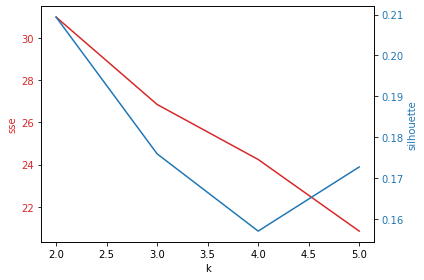

In [210]:
x = [i for i in range(2,max_val)]
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('sse', color=color)
ax1.plot(x, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In this case, we will take between $k = 5$, so we try to minimize the distorsion (SSE) and maximize the silhouette, so we can reach a trade off. Once we have selected the value of $k$ we can proceed with the algorithm execution. 

In [211]:
k = 5

#### K-means execution

In [212]:
km = KMeans(n_clusters = k, init = init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km = km.fit_predict(X_pca) # fit -> build the model && predict -> execute the model. in this library they execute both, since in ML they are not differentiated. This method, groups it.
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_pca, y_km))
      
print('Distortion: %.2f' % km.inertia_)
y_km

Silhouette Coefficient: 0.173
Distortion: 20.85


array([2, 1, 0, 3, 4, 0, 1, 2, 1, 4, 2, 2, 1, 1, 1, 4, 1, 1, 3, 0, 1, 4,
       3, 2, 3, 0, 3], dtype=int32)

Once the algorithm has been executed, we move on to the visualization and try to reach some conclusions.

#### Visualization

In [213]:
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1], color = km.labels_)

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1], text = df.iloc[i,:].team_name)

font_dict = dict(family="Calibri",size=16,color="#b6b0ff")
for i in range(0,len(km.cluster_centers_)):
    fig.add_annotation(x = km.cluster_centers_[i,0], y = km.cluster_centers_[i,1], text = f'Centroid{i}', showarrow = True, arrowhead = 4, arrowwidth = 3, borderpad = 3, font = font_dict)

fig.show()

If we compare this scatterplot with the one seen in class notebook, we can remark how groups are more balance. I mean, there are number of teams per cluster is more similar between them than the result from class.

### k-Means Interpretation

Now, it is turn to give some interpretations for the results of the clustering algorithm.

Let's first add some usefull/necessary columns to the dataframe.

In [214]:
attack_df['team_round'] = df['team_round']
attack_df['kmeans_cluster'] = km.labels_

#### Group 1 & Group 4

In [215]:
attack_df[['goals_scored_average', 'xg_total_average', 'kmeans_cluster']].groupby('kmeans_cluster').describe()

goals_scored_average                                          \
                              count      mean       std   min     25%   50%   
kmeans_cluster                                                                
0                               4.0  2.040000  0.274833  1.67  1.9175  2.10   
1                               9.0  0.724444  0.108985  0.67  0.6700  0.67   
2                               5.0  1.440000  0.378153  1.00  1.2000  1.50   
3                               5.0  1.500000  0.190394  1.25  1.4000  1.50   
4                               4.0  0.835000  0.330000  0.67  0.6700  0.67   

                             xg_total_average                            \
                   75%   max            count      mean       std   min   
kmeans_cluster                                                            
0               2.2225  2.29              4.0  1.477500  0.259663  1.11   
1               0.7500  1.00              9.0  1.002222  0.337964  0.58   
2               1.5000  2.00              5.0  1.200000  0.146799  0.98   
3               1.6000  1.75              5.0  1.588000  0.616295  0.91   
4               0.8350  1.33              4.0  0.832500  0.187150  0.70   

                                           
                  25%   50%     75%   max  
kmeans_cluster                             
0               1.395  1.55  1.6325  1.70  
1               0.790  0.87  1.1700  1.61  
2               1.190  1.20  1.2400  1.39  
3               1.170  1.49  1.9000  2.47  
4               0.745  0.76  0.8475  1.11

After analyzing these two variables, we can see the principal difference of group 1. The `goals_scored_average` is significantly lower than the other two groups. Furthermore, the `xg_total_average` tells us that it was expected that this group scored a low number of goals and they managed to score even less.

This cluster (**group 1**) corresponds to those teams that **did a poor performance in spite of expecting more than they did**. As expected, none of them played well enough to score the necessary goals to pass to the higher rounds.

But, in other hand, we have group 4, which also has low values in those two variables. So, why are they not in the same cluster?

We think this can be due to the variable `xg_total_average`, which tells us that, the expected result was low and so the real result.

As general conclusion for cluster 4, it has the teams having **a low expected performance and, actually, a low real performance**.

**_Note:_** We can observe how these two clusters where the worst teams in the competition.

In [216]:
attack_df[attack_df['kmeans_cluster'] == 1]['team_round'] 

1     Group stage
7     Round of 16
12    Group stage
16    Round of 16
17    Group stage
18    Group stage
20    Group stage
21    Group stage
24    Group stage
Name: team_round, dtype: object

In [217]:
attack_df[attack_df['kmeans_cluster'] == 4]['team_round'] 

5     Group stage
13    Group stage
19    Group stage
25    Group stage
Name: team_round, dtype: object

#### Group 3 & Group 0
Let's analyse the following variables:

In [218]:
attack_df[['goals_scored_set_play_average', 'crosses_completed_average', 'shots_inside_penalty_area_per_goal_average', 'kmeans_cluster']].groupby('kmeans_cluster').describe()

goals_scored_set_play_average                            \
                                       count      mean       std   min   
kmeans_cluster                                                           
0                                        4.0  0.525000  0.387341  0.14   
1                                        9.0  0.351111  0.208833  0.00   
2                                        5.0  0.388000  0.259942  0.00   
3                                        5.0  0.600000  0.355317  0.20   
4                                        4.0  0.247500  0.165000  0.00   

                                           crosses_completed_average  \
                   25%   50%     75%   max                     count   
kmeans_cluster                                                         
0               0.2525  0.48  0.7525  1.00                       4.0   
1               0.2500  0.33  0.3300  0.67                       9.0   
2               0.3300  0.40  0.5000  0.71                       5.0   
3               0.2500  0.75  0.8000  1.00                       5.0   
4               0.2475  0.33  0.3300  0.33                       4.0   

                          ...              \
                    mean  ...   75%   max   
kmeans_cluster            ...               
0               2.562500  ...  2.86  2.86   
1               1.971111  ...  2.00  3.00   
2               1.522000  ...  1.60  1.75   
3               3.010000  ...  3.75  4.25   
4               1.750000  ...  2.25  3.00   

               shots_inside_penalty_area_per_goal_average                      \
                                                    count      mean       std   
kmeans_cluster                                                                  
0                                                     4.0  4.400000  0.535413   
1                                                     9.0  9.888889  2.123349   
2                                                     5.0  6.440000  1.178134   
3                                                     5.0  7.380000  1.411382   
4                                                     4.0  6.325000  0.925113   

                                                 
                min    25%    50%     75%   max  
kmeans_cluster                                   
0               3.7  4.225   4.45   4.625   5.0  
1               6.7  9.000  10.00  11.500  13.5  
2               4.6  6.000   7.00   7.000   7.6  
3               5.5  7.000   7.20   7.800   9.4  
4               5.3  5.825   6.25   6.750   7.5  

[5 rows x 24 columns]

We can observe, in the variable `goals_scored_set_play_average` and `crosses_completed_average` how the group 3 is the leader one, but we cannot really differentiate them regarding group 0. Until we check the variable `shots_inside_penalty_area_per_goal_average`, when group 3 is not as good as group 0, since it needs more shots inside penalty area to score (which is not good).

From these variables we might appreciate how, group 3 has **a good strategic and team game** when comes to dead ball play or crossing to the area, while group 0 **also has the ability to play searching holes in the deffense in some occasions**.

In fact, if we check the [final branching](https://www.google.com/search?q=mundial+rusia+resultado+equipos&rlz=1C1VDKB_esES977ES977&oq=mundial+rusia+resultado+equipos&aqs=chrome..69i57j33i160j33i22i29i30.15330j1j7&sourceid=chrome&ie=UTF-8#sie=t;/m/0356gk;2;/m/030q7;st;fp;1;;;) of the competition, when a team of group 3 played against a team of group 0, normally, the winner was the one from group 0, which reasserts the fact of **having a similar way of playing** -by crossing and set plays-, but cluster 0 is more versatile than cluster 3. Another way of confirming these fact is by checking how the teams of group 0 reached higher positions (next two cells):

In [219]:
attack_df[attack_df['kmeans_cluster'] == 3]['team_round'] 

3     Quarter-finals
22       Round of 16
27       Round of 16
29       Round of 16
31    Quarter-finals
Name: team_round, dtype: object

In [220]:
attack_df[attack_df['kmeans_cluster'] == 0]['team_round'] 

2              Third
6          Runner-up
23    Quarter-finals
30       Group stage
Name: team_round, dtype: object

#### Group 2
As we can imagine, this group might seem different than the other previous two clusters. When analysing these variables we have that:

In [221]:
attack_df[['shot_precision_percentage','shots_scored_inside_penalty_area_percentage','kmeans_cluster']].groupby('kmeans_cluster').describe()

shot_precision_percentage                                      \
                                   count      mean       std    min      25%   
kmeans_cluster                                                                 
0                                    4.0  0.428000  0.073144  0.330  0.40425   
1                                    9.0  0.354667  0.043003  0.270  0.33300   
2                                    5.0  0.498600  0.048221  0.433  0.46500   
3                                    5.0  0.445000  0.054886  0.389  0.40000   
4                                    4.0  0.370250  0.126152  0.191  0.33350   

                                       \
                  50%      75%    max   
kmeans_cluster                          
0               0.438  0.46175  0.506   
1               0.370  0.38100  0.407   
2               0.516  0.52900  0.550   
3               0.447  0.46300  0.526   
4               0.405  0.44175  0.480   

               shots_scored_inside_penalty_area_percentage                    \
                                                     count    mean       std   
kmeans_cluster                                                                 
0                                                      4.0  0.9225  0.075000   
1                                                      9.0  1.0000  0.000000   
2                                                      5.0  0.7740  0.077974   
3                                                      5.0  0.7840  0.091815   
4                                                      4.0  1.0000  0.000000   

                                                  
                 min     25%    50%    75%   max  
kmeans_cluster                                    
0               0.82  0.9025  0.935  0.955  1.00  
1               1.00  1.0000  1.000  1.000  1.00  
2               0.67  0.7100  0.830  0.830  0.83  
3               0.67  0.7100  0.800  0.860  0.88  
4               1.00  1.0000  1.000  1.000  1.00

Surprisingly, group 2 has a quite high shot precision (the highest one) but, in other hand, is the cluster with less goals inside the penalty area. How can these two fact be related?

We firmly think that is because the cluster 2 game style is highly seaching some holes in the front of the penalty area (but not inside, obviously). In other words, the game style of these teams is **more focused on powerful shots outside the area**.

As a final comment regarding cluster 2, the team rounds of the teams are quite diversed, highlighting France, which won the competition.

### Sum up
As conclusion, we can assign the following labels to each cluster:
- Group 0: Good deadball and cross game plus adaptative capability.
- Group 1: Disappointing performance.
- Group 2: Center-oriented and long shots game style.
- Group 3: Good deadball and cross game.
- Group 4: Bad performance.

## 5. Clustering: Hierarchical Clustering
Now it is time to try the clustering using a different algorithm. This time, we will be using **Hierarchical Agglomerative Clustering**. This algorithm, mainly consists allows us to define a final structure of the data starting from all the individual points considered as clusters and mergin the closest ones.

Again, we will use the normalized data (using the MinMaxScaler, in section 2.1 of this Colab Notebook), and more specifically, the attacking data. By this way, we can compare the results with the ones obtained from the clustering done with the K-means algorithm (Section 4).

### Similarity matrix
Let's plot the similarity matrix between the variables.

In [222]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(X_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning:

sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3



### Execution

Once we have all the preprocessing, we have to stop a bit in the concept of the intercluster distances. Mainly, we have seen two types in class:
- Single Link
- Complete Link

We tried with both methods and the obtained results are quite concordant with the theory seen in class: Single link could be quite usefull for detecting outliers but the dendrogram is quite a disaster; Complete link allows a better understanding of the dendrogram.

Since the outliers where detected previously with DBSCAN, single link will only make things more complicated than it should, so, we will only consider the results of Complete Link intercluster distance.

Complete link measures the intercluster distance as the maximum distance between two clusters, i.e., is represented with the farthest pair of points within those two clusters. Let's perform the algorithm.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



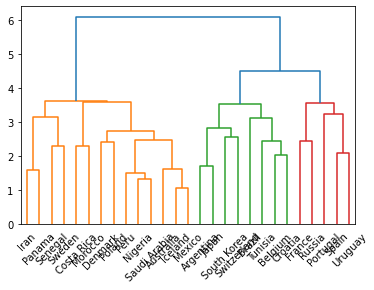

<Figure size 432x288 with 0 Axes>

In [223]:
# 3.2. Building the Dendrogram
clusters = cluster.hierarchy.linkage(matsim, method = 'complete')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
dend = cluster.hierarchy.dendrogram(clusters, labels = df['team_name'].values, color_threshold=4)

# 3.2.1 Visualization
f = plt.figure()
plt.show()

Comparing these two dendrograms it is obvious that the most readable and understandable one is this last one. The dendrogram of single link is quite chaotic, we could say.

In spite of single link being useful for detecting outliers, it is not our interest here, we want to group the teams, so let's end up the clustering process using the Complete Link results.

Now, it's time to choose where to cut the dendrogram to obtain groups. We think that a good option would be cutting in 4.

In [224]:
#@title Choose cut level {run: "auto"}
cut  = 4 #@param { type: "slider", min: 0, max: 7, step: 0.5}

In [225]:
labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

labels

array([2, 1, 2, 2, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1,
       3, 1, 2, 2, 3], dtype=int32)

In [226]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(norm_attack, labels))

Estimated number of clusters: 3
Silhouette Coefficient: 0.161


#### Visualization
As we can see, we found 6 clusters, let's plot them using the PCA projection.

In [227]:
pca = PCA (n_components = 2)
X_pca = pca.fit_transform(norm_attack)
print (pca.explained_variance_ratio_)

#plotting orginal points with color related to label
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1], color = labels)

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1], text = df.iloc[i,:].team_name)
fig.show()

[0.32240899 0.16146561]


### Hierarchical interpretation

#### Group 1

As we can see in this barplot, **group 1** corresponds to those teams that **did a poor performance in general**. As average, they had scored more or less half of the goals compared to the other groups. Furthermore, those teams were expected to score few goals, but they scored less than expected.

In addition, **group 1** corresponds to a mixture of teams from the clusters 1 and 4 generated in K-means.

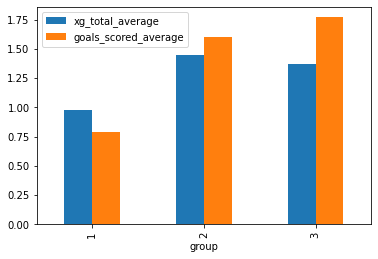

In [241]:
attack_df['group'] = labels


res = attack_df[['xg_total_average','goals_scored_average','group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

#### Group 2 & Group 3

We can see that the play style of **group 3** is related to those teams that prefer to **take shots outside the area and not getting really close into the penalty area**.

In contrast, **group 2** play style is the opposite than **group 3**, as they have a **deeper game style.** As a result, they prefer to **combine and shot inside penalty** area rather than shooting outside it.

This can also be confirmed if we take a look at the barplot that compares `shots_scored_outside.penalty_area_percentage` and `crosses_completed_percentage`. These two features are related, because if a team decides to shot less outside penalty area, there are more possibilites of topping off crosses.

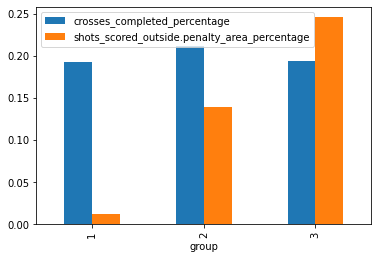

In [248]:
attack_df['group'] = labels


res = attack_df[['crosses_completed_percentage','shots_scored_outside.penalty_area_percentage','group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

We firmly think, that those teams from **group 3** have players with more powerful shots that are not afraid of shooting outside penalty area. As a result, we can see that they are the ones with more `goals_scored_free_kick_average`.

Furthermore, we can see that group 3 stands out in `goals_scored_set_play_average`. At a first glance, this doesn't fit with group 2 having a deeper gameplay, but if we take a look into the `goals_scored_free_kick_average` we can observe that they also dominate in free kicks.

In [252]:
attack_df[['goals_scored_set_play_average','goals_scored_free_kick_average','group']].groupby('group').describe()

goals_scored_set_play_average                                       \
                              count    mean       std   min    25%   50%   
group                                                                      
1                              14.0  0.3250  0.189402  0.00  0.270  0.33   
2                               8.0  0.2975  0.209063  0.00  0.185  0.27   
3                               5.0  0.8520  0.138816  0.71  0.750  0.80   

                    goals_scored_free_kick_average                            \
          75%   max                          count      mean       std   min   
group                                                                          
1      0.3300  0.67                           14.0  0.071429  0.193425  0.00   
2      0.3725  0.67                            8.0  0.058750  0.120052  0.00   
3      1.0000  1.00                            5.0  0.368000  0.258592  0.14   

                                
        25%   50%    75%   max  
group                           
1      0.00  0.00  0.000  0.67  
2      0.00  0.00  0.035  0.33  
3      0.25  0.25  0.400  0.80

### Sum up
As conclusion, we can assign the following labels to each cluster:
- Group 1: Bad performance.
- Group 2: Deep game style.
- Group 3: Long shots game style.
